**Taken from [kaggle user rajeshjnv](https://www.kaggle.com/rajeshjnv/heart-disease-classification-neural-network)**

## Initialize the notebook

In [ ]:
!pip install kaggle

In [ ]:
# Upload your kaggle api key
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!rm -r data/
!mkdir data/

rm: cannot remove 'data/': No such file or directory


In [ ]:
!kaggle datasets download -d ronitf/heart-disease-uci

  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 5.40MB/s]


In [ ]:
!mv heart-disease-uci.zip ./data

In [ ]:
!cd data && unzip heart-disease-uci.zip

Archive:  heart-disease-uci.zip
  inflating: heart.csv               


In [ ]:
import numpy as n
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Analyze data

1.age: The person's age in years

2.sex: The person's sex (1 = male, 0 = female)

3.cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)

4.trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)

5.chol: The person's cholesterol measurement in mg/dl

6.fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

7.restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)

8.thalach: The person's maximum heart rate achieved

9.exang: Exercise induced angina (1 = yes; 0 = no)

10.oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)

11.slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)

12.ca: The number of major vessels (0-3)

13.thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)

14.target: Heart disease (0 = no, 1 = yes)

In [ ]:
df = pd.read_csv("./data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
df.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


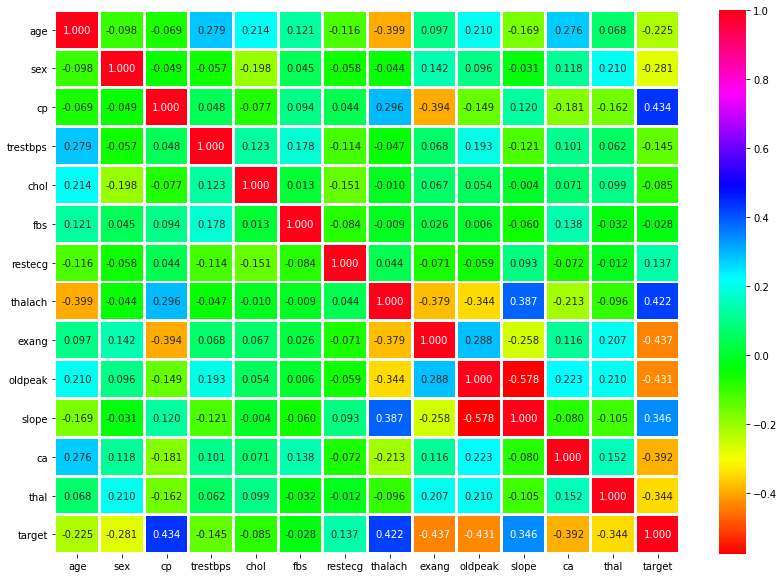

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

In [ ]:
df.groupby("cp", as_index=False)["target"].mean()

,cp,target
0,0,0.272727
1,1,0.820000
2,2,0.793103
3,3,0.695652


In [ ]:
df.groupby('slope',as_index=False)['target'].mean()

,slope,target
0,0,0.428571
1,1,0.350000
2,2,0.753521


In [ ]:
df.groupby('thal',as_index=False)['target'].mean()

,thal,target
0,0,0.500000
1,1,0.333333
2,2,0.783133
3,3,0.239316


In [ ]:
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.601449,0.826087,0.478261,134.398551,251.086957,0.159420,0.449275,139.101449,0.550725,1.585507,1.166667,1.166667,2.543478
1,52.496970,0.563636,1.375758,129.303030,242.230303,0.139394,0.593939,158.466667,0.139394,0.583030,1.593939,0.363636,2.121212


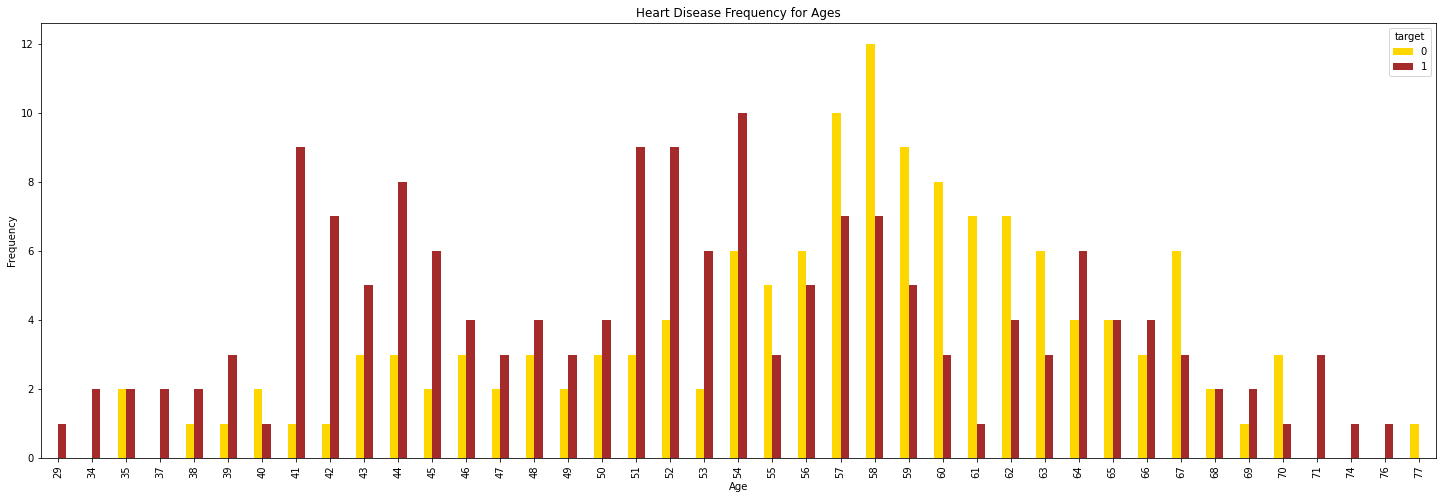

In [ ]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(25,8),color=['gold','brown'])
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

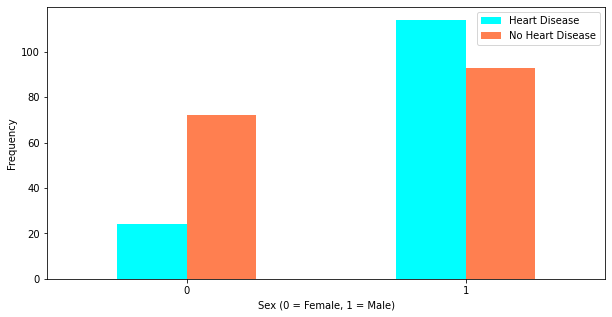

In [ ]:
pd.crosstab(df.sex,df.target).plot(kind="bar",figsize=(10,5),color=['cyan','coral' ])
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Heart Disease", "No Heart Disease"])
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'tresbps vs target')

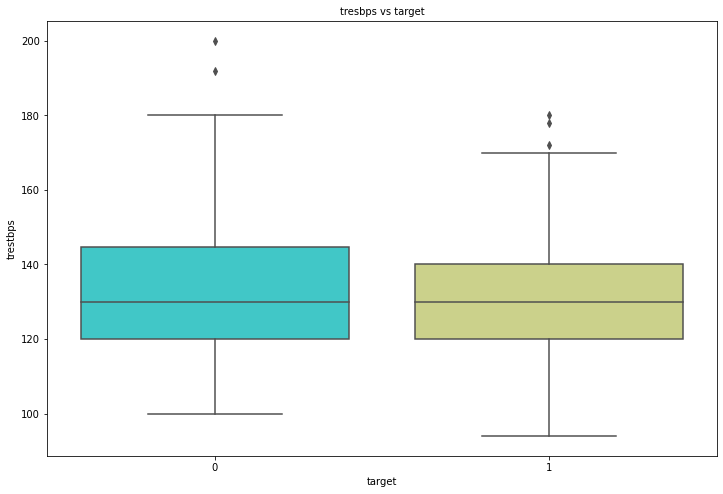

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(df['target'], df['trestbps'], palette = 'rainbow')
plt.title('tresbps vs target', fontsize = 10)

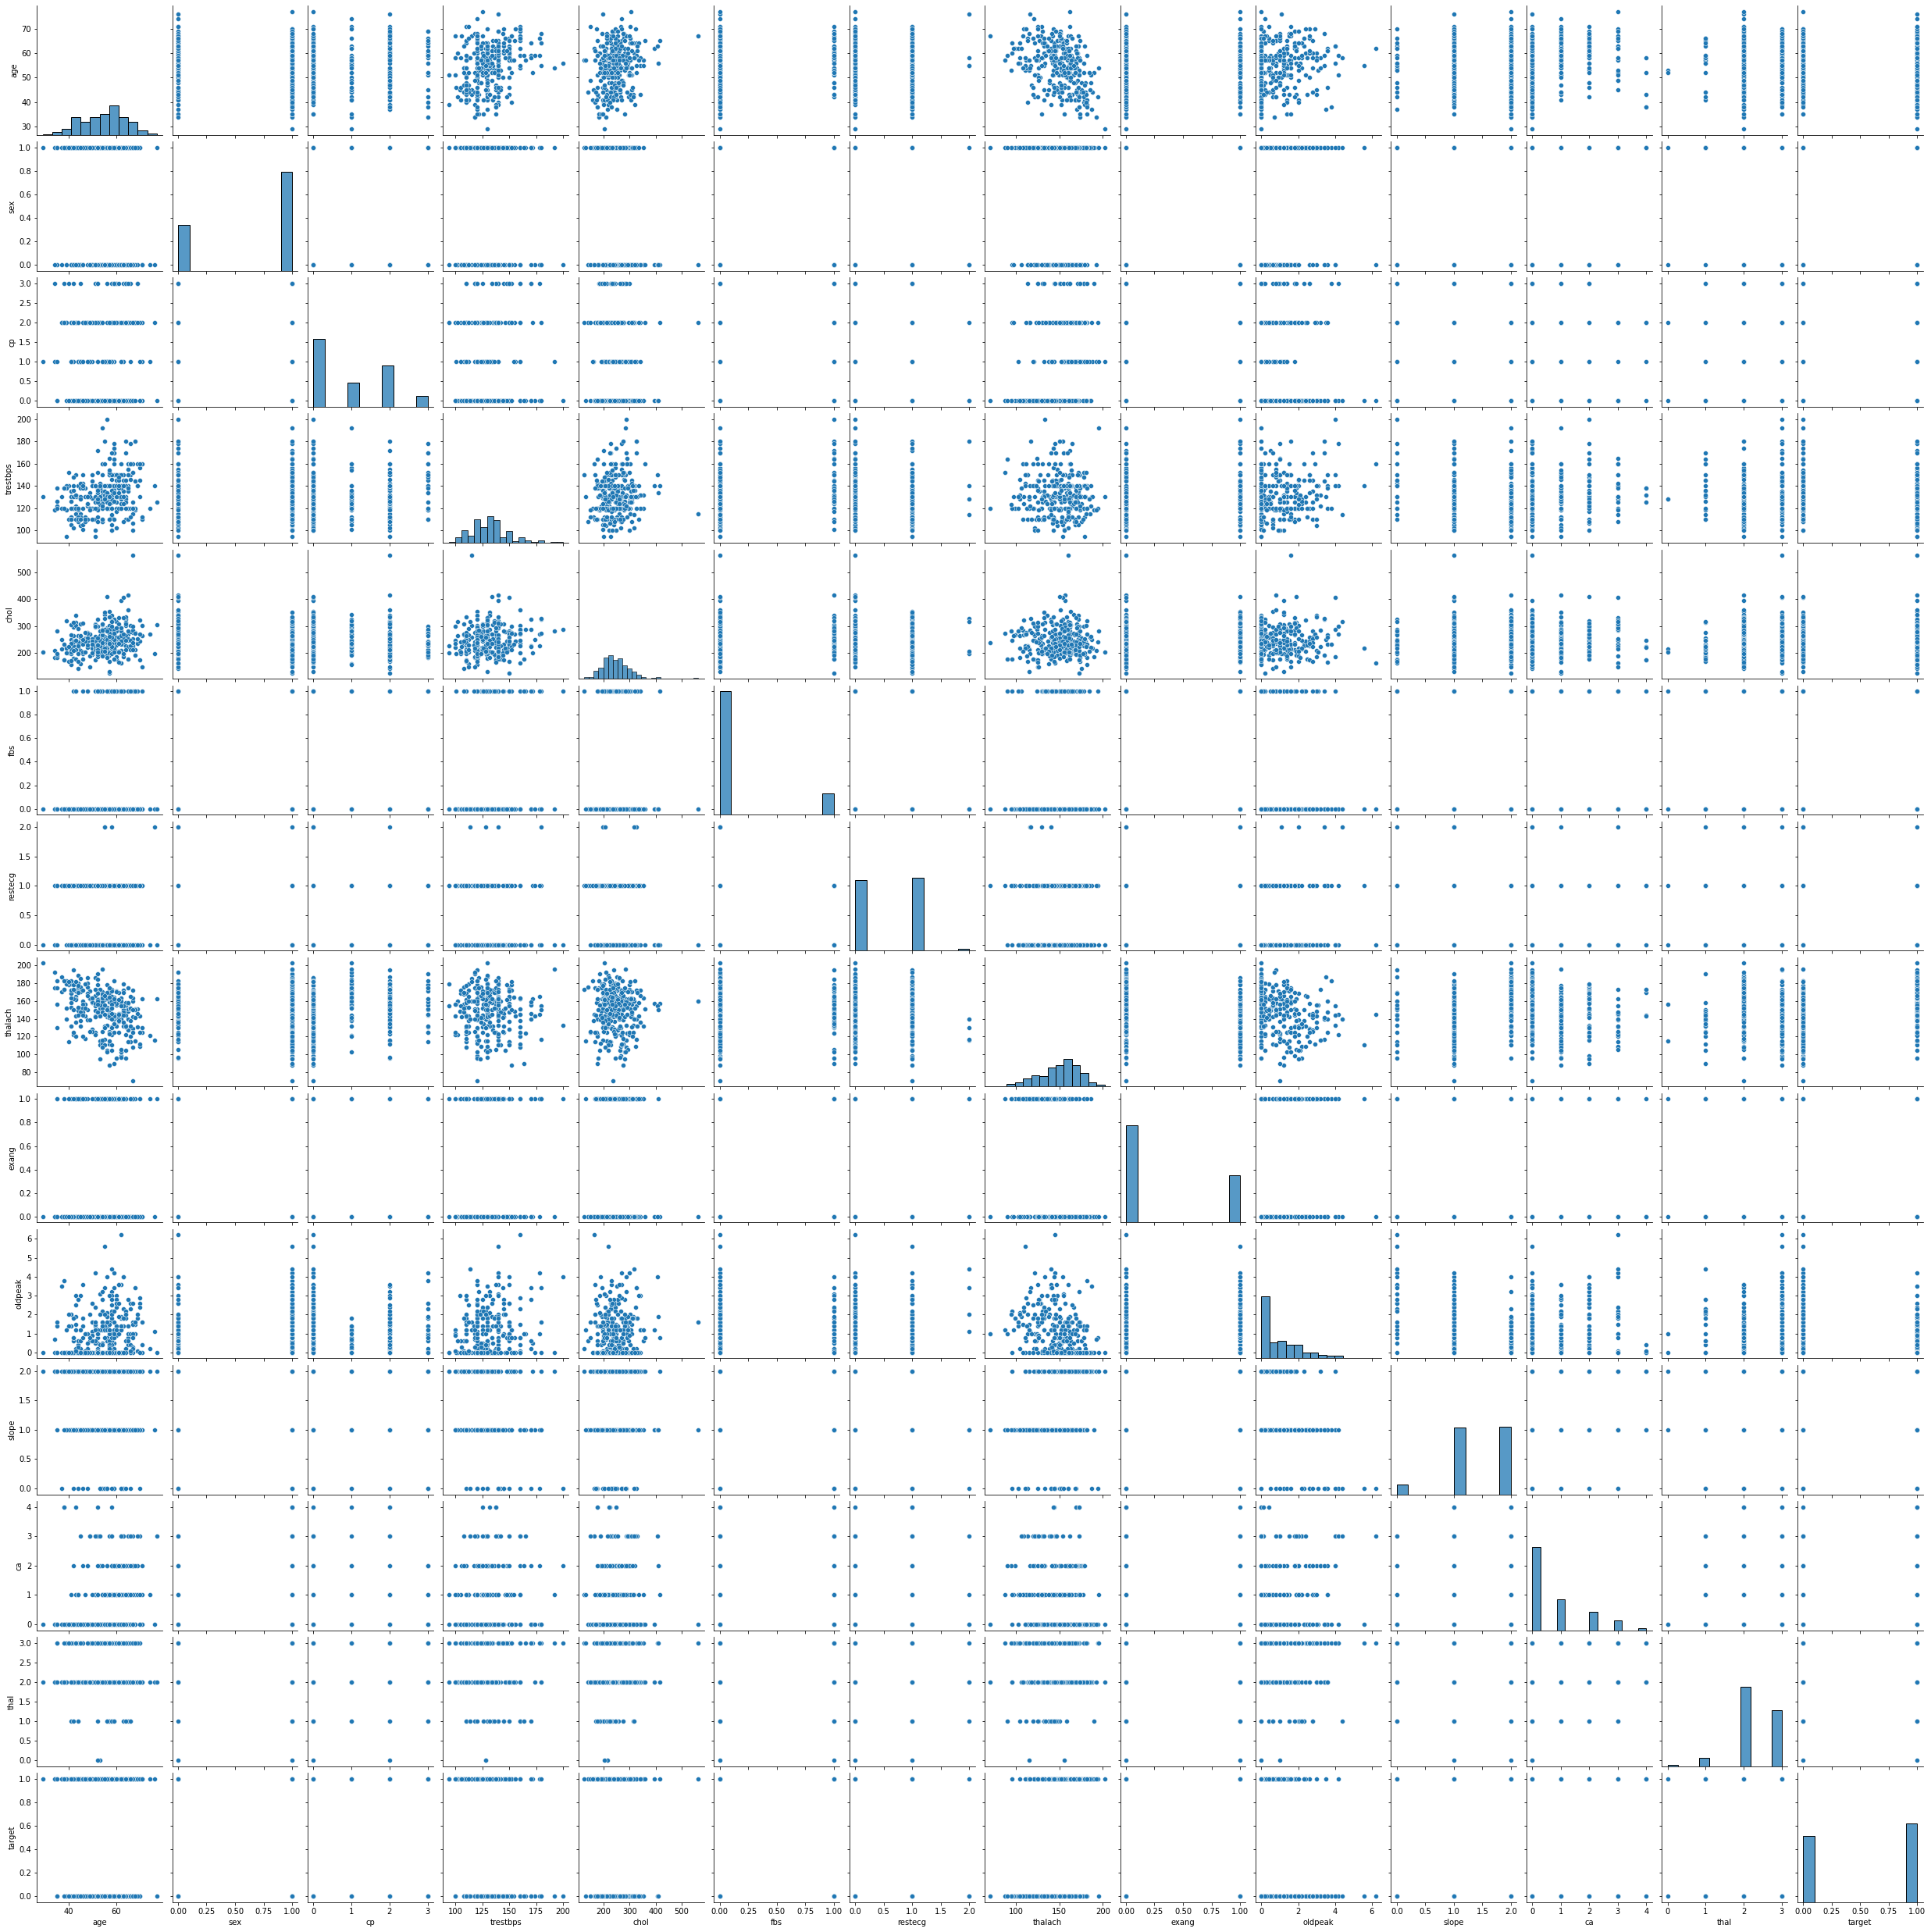

In [ ]:
sns.pairplot(data=df)

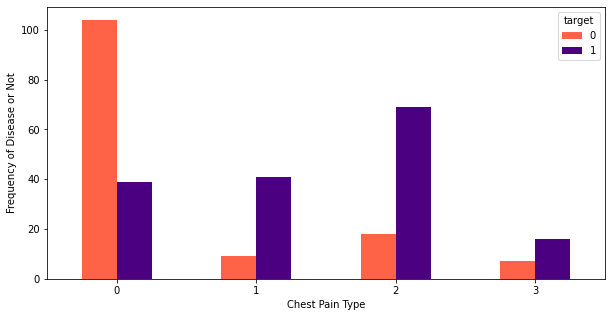

In [ ]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(10,5),color=['tomato','indigo' ])
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

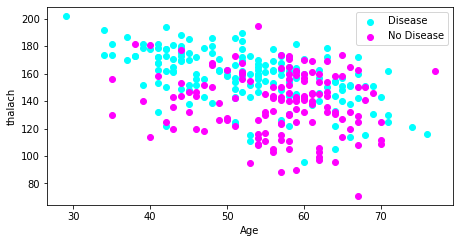

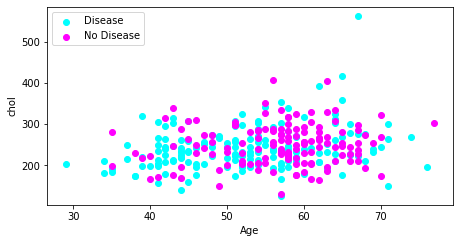

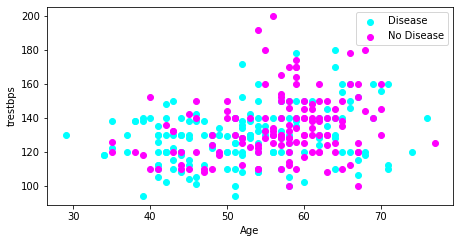

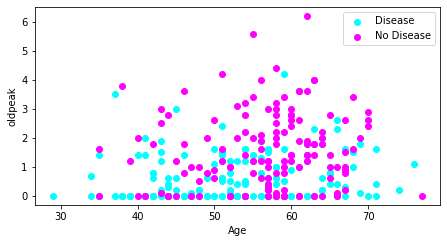

In [ ]:
for feature in ["thalach", "chol", "trestbps", "oldpeak"]:
  plt.figure(figsize=(16,8))
  plt.subplot(2,2,1)
  plt.scatter(x=df.age[df.target==1],y=df[feature][df.target==1],c='cyan')
  plt.scatter(x=df.age[df.target==0],y=df[feature][df.target==0],c='fuchsia')
  plt.xlabel('Age')
  plt.ylabel(feature)
  plt.legend(['Disease','No Disease'])

## Preprocess data

In [ ]:
labels_to_encode = ["cp", "slope", "thal", "restecg"]

In [ ]:
# one hot encoding
for label in labels_to_encode:
  one_hot = pd.get_dummies(df[label], prefix=label)
  df = pd.concat([df, one_hot], axis=1)
  df.drop([label], axis=1, inplace=True)

In [ ]:
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
3,56,1,120,236,0,178,0,0.8,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0


In [ ]:
X = df.drop("target", axis=1)
print(len(X.columns))
y = df.target.values

23


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## Build the models

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import History 
import warnings

In [ ]:
## print the loss for the model using the history
def print_loss(model, epoch_range, final_epoch):
  history = model.history.history["loss"]
  for i, loss in enumerate(history):
    if (i) % epoch_range == 0:
      print(f"Loss for epoch {i}:\t {loss}")
  print(f"Loss for epoch {final_epoch}:\t {history[-1]}")

In [ ]:
class NN():

  def compile(self, optimizer="adam", loss="binary_crossentropy"):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  def train(self, X_train, Y_train, batch_size, num_epochs):
      self.model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, callbacks=[self.history], verbose=0)


**Basic nn with one hidden layer**

In [ ]:
class NN_basic(NN):

  def __init__(self):
    self.history = History()
    self.model = Sequential(name="basic_NN")
    self.model.add(Dense(11, activation='relu', input_dim=23))
    self.model.add(Dense(11, activation = 'relu'))
    self.model.add(Dense(1, activation='sigmoid'))


In [ ]:
%%time
basic_NN = NN_basic()
basic_NN.compile()
basic_NN.model.summary()
# x_train, y_train, batch_size, num_epochs
basic_NN.train(X_train, y_train, 10, 200)

Model: "basic_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 11)                264       
_________________________________________________________________
dense_30 (Dense)             (None, 11)                132       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 12        
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
CPU times: user 5.55 s, sys: 509 ms, total: 6.06 s
Wall time: 4.52 s


In [ ]:
print_loss(basic_NN.model, 10, 200)

Loss for epoch 0:	 0.7535858154296875
Loss for epoch 10:	 0.38972344994544983
Loss for epoch 20:	 0.32065150141716003
Loss for epoch 30:	 0.2872467339038849
Loss for epoch 40:	 0.259590208530426
Loss for epoch 50:	 0.2365477979183197
Loss for epoch 60:	 0.21791020035743713
Loss for epoch 70:	 0.19974954426288605
Loss for epoch 80:	 0.18196187913417816
Loss for epoch 90:	 0.16527442634105682
Loss for epoch 100:	 0.1518961489200592
Loss for epoch 110:	 0.13634812831878662
Loss for epoch 120:	 0.12263365834951401
Loss for epoch 130:	 0.11029072105884552
Loss for epoch 140:	 0.09945957362651825
Loss for epoch 150:	 0.09032630920410156
Loss for epoch 160:	 0.08168129622936249
Loss for epoch 170:	 0.0752863958477974
Loss for epoch 180:	 0.06748311221599579
Loss for epoch 190:	 0.06115129217505455
Loss for epoch 200:	 0.05552402138710022


accuracy of the model:  0.819672131147541


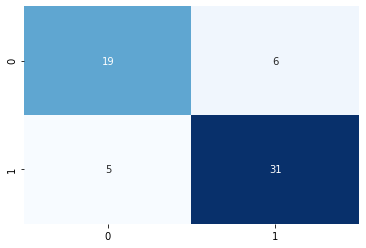

In [ ]:
y_pred_basic = basic_NN.model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_basic.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)
#accuracy score
ac=accuracy_score(y_test, y_pred.round())
print('accuracy of the model: ',ac)

**Lets try a deeper model**

In [ ]:
class NN_4_deep(NN):

  def __init__(self):
    self.history = History()
    self.model = Sequential(name="NN_4_deep")
    self.model.add(Dense(11, activation='relu', input_dim=23))
    self.model.add(Dense(11, activation = 'relu'))
    self.model.add(Dense(9, activation = 'relu'))
    self.model.add(Dense(5, activation = 'relu'))
    self.model.add(Dense(1, activation='sigmoid'))

In [ ]:
%%time
NN_4_deep = NN_4_deep()
NN_4_deep.compile()
NN_4_deep.model.summary()
# x_train, y_train, batch_size, num_epochs
NN_4_deep.train(X_train, y_train, 10, 500)

Model: "NN_4_deep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 11)                264       
_________________________________________________________________
dense_43 (Dense)             (None, 11)                132       
_________________________________________________________________
dense_44 (Dense)             (None, 9)                 108       
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 50        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 6         
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________
CPU times: user 14.6 s, sys: 1.37 s, total: 15.9 s
Wall time: 11.4 s


In [ ]:
print_loss(NN_4_deep.model, 10, 200)

Loss for epoch 0:	 0.6791704297065735
Loss for epoch 10:	 0.35780155658721924
Loss for epoch 20:	 0.29071924090385437
Loss for epoch 30:	 0.24992774426937103
Loss for epoch 40:	 0.2096097618341446
Loss for epoch 50:	 0.17164263129234314
Loss for epoch 60:	 0.14170017838478088
Loss for epoch 70:	 0.12059170007705688
Loss for epoch 80:	 0.09891057759523392
Loss for epoch 90:	 0.07413101941347122
Loss for epoch 100:	 0.05464780330657959
Loss for epoch 110:	 0.03859868273139
Loss for epoch 120:	 0.019810469821095467
Loss for epoch 130:	 0.011817014776170254
Loss for epoch 140:	 0.00624642102047801
Loss for epoch 150:	 0.003693964099511504
Loss for epoch 160:	 0.0022799703292548656
Loss for epoch 170:	 0.001488795387558639
Loss for epoch 180:	 0.0010353230172768235
Loss for epoch 190:	 0.0007446881500072777
Loss for epoch 200:	 0.0005432905745692551
Loss for epoch 210:	 0.00040337504469789565
Loss for epoch 220:	 0.00030858477111905813
Loss for epoch 230:	 0.00023978587705641985
Loss for ep

accuracy of the model:  0.819672131147541


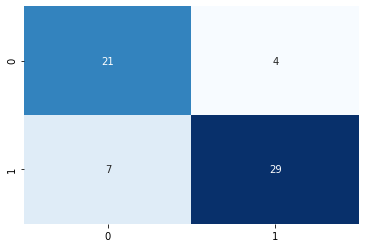

In [ ]:
y_pred_4_deep = NN_4_deep.model.predict(X_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)
#accuracy score
ac=accuracy_score(y_test, y_pred.round())
print('accuracy of the model: ',ac)

In [ ]:
wrong_preds=[]
y_pred_4_deep = y_pred_4_deep.round()
mask = [y_pred_4_deep == y_test][0]
for i, row in enumerate(mask):
  if not mask[0][i]:
    wrong_preds.append(X_train[i])

wrong_preds

[array([ 0.80451559, -1.59963231, -0.08206277,  0.30669838, -0.41119597,
        -2.30161104, -0.67663234,  0.17098467,  0.237665  , -0.9437293 ,
        -0.45164156,  1.61614984, -0.30015011, -0.25705893,  1.13270423,
        -1.        , -0.06441566, -0.24779731, -1.11388543,  1.26576085,
        -1.0082989 ,  1.03362279, -0.11203705]),
 array([-0.92801186, -1.59963231, -1.57748371, -0.80983387, -0.41119597,
         0.97505696, -0.67663234, -0.9398419 , -0.75397173, -0.9437293 ,
         2.21414521, -0.61875451, -0.30015011, -0.25705893, -0.882843  ,
         1.        , -0.06441566, -0.24779731,  0.8977584 , -0.79003865,
        -1.0082989 ,  1.03362279, -0.11203705]),
 array([-1.25286076,  0.62514366,  0.03757091,  0.00390997,  2.43193045,
        -0.29192133,  1.47790748, -0.84727302,  3.2125752 ,  1.05962589,
        -0.45164156, -0.61875451, -0.30015011, -0.25705893,  1.13270423,
        -1.        , -0.06441566, -0.24779731, -1.11388543,  1.26576085,
         0.99176941, -0.96